# Entrenamiento de Detector de Plazas (SVM)

Este notebook entrena un modelo de Machine Learning (**Support Vector Machine**) para clasificar plazas como Libres u Ocupadas.

## ¿Por qué ML?
En lugar de usar un umbral fijo manual (e.g., >500 píxeles), el modelo aprenderá automáticamente la mejor frontera de decisión basándose en:
1.  **Intensidad**: Cantidad de píxeles blancos (bordes).
2.  **Textura**: Varianza de la imagen (los coches tienen más textura que el asfalto liso).
3.  **Color (Saturación)**: El asfalto es gris (baja saturación), los coches suelen tener color.

---

In [1]:
import cv2
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Configuración
plt.rcParams['figure.figsize'] = (10, 6)
DATA_DIR = Path("data")
GT_FILE = "ground_truth.json"
PLAZAS_FILE = "plazas.pickle"
MODEL_FILE = "model.pkl"

## 1. Cargar Datos y Definir Pipeline de Características

In [ ]:
def cargar_datos():
    # 1. Cargar Plazas (ROIs)
    if not Path(PLAZAS_FILE).exists():
        raise FileNotFoundError(f"Falta {PLAZAS_FILE}")
    with open(PLAZAS_FILE, 'rb') as f:
        plazas = pickle.load(f)
        
    # 2. Cargar Etiquetas
    if not Path(GT_FILE).exists():
        raise FileNotFoundError(f"Falta {GT_FILE}. ¡Etiqueta imágenes primero!")
    with open(GT_FILE, 'r') as f:
        ground_truth = json.load(f)
        
    print(f"✅ Plazas cargadas: {len(plazas)}")
    print(f"✅ Imágenes etiquetadas: {len(ground_truth)}")
    return plazas, ground_truth

def preprocess_image(image):
    #Preprocesamiento base: Grises + CLAHE + Blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    return blur

def extract_features(roi_gray, roi_binary, roi_color):
    
    # Feature 1: Pixel Count (Bordes)
    pixels = cv2.countNonZero(roi_binary)
    
    # Feature 2: Texture (Std Dev)
    # Asfalto es uniforme (baja std), Coche es variado (alta std)
    match_mean, match_std = cv2.meanStdDev(roi_gray)
    texture = match_std[0][0]
    
    # Feature 3: Saturation
    hsv = cv2.cvtColor(roi_color, cv2.COLOR_BGR2HSV)
    s_mean, s_std = cv2.meanStdDev(hsv[:,:,1]) # Canal 1 es Saturation
    saturation = s_mean[0][0]
    
    return [pixels, texture, saturation]

## 2. Construir Dataset (X, y)
Recorremos las imágenes etiquetadas y extraemos las características de cada plaza.

In [9]:
plazas, ground_truth = cargar_datos()

X = []
y = []

print("⏳ Procesando imágenes...")
for img_name, labels in ground_truth.items():
    img_path = DATA_DIR / img_name
    if not img_path.exists(): continue
    
    image = cv2.imread(str(img_path))
    processed = preprocess_image(image)
    
    # Binarización adaptativa (para feature de bordes)
    binary = cv2.adaptiveThreshold(processed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY_INV, 25, 15)
    binary = cv2.medianBlur(binary, 5)
    
    for idx, rect in enumerate(plazas):
        if idx >= len(labels): break
        
        # Extraer ROI
        x, y_pos, w, h = rect
        roi_gray = processed[y_pos:y_pos+h, x:x+w]
        roi_binary = binary[y_pos:y_pos+h, x:x+w]
        roi_color = image[y_pos:y_pos+h, x:x+w]
        
        # Extraer Features y Label
        features = extract_features(roi_gray, roi_binary, roi_color)
        label = labels[idx]
        
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

print(f"\n📊 Dataset creado: {X.shape[0]} muestras")
print(f"   - Libres (0): {np.sum(y==0)}")
print(f"   - Ocupadas (1): {np.sum(y==1)}")

✅ Plazas cargadas: 51
✅ Imágenes etiquetadas: 8
⏳ Procesando imágenes...

📊 Dataset creado: 408 muestras
   - Libres (0): 85
   - Ocupadas (1): 323


## 3. Visualizar Datos
Confirmamos visualmente que las clases son separables.

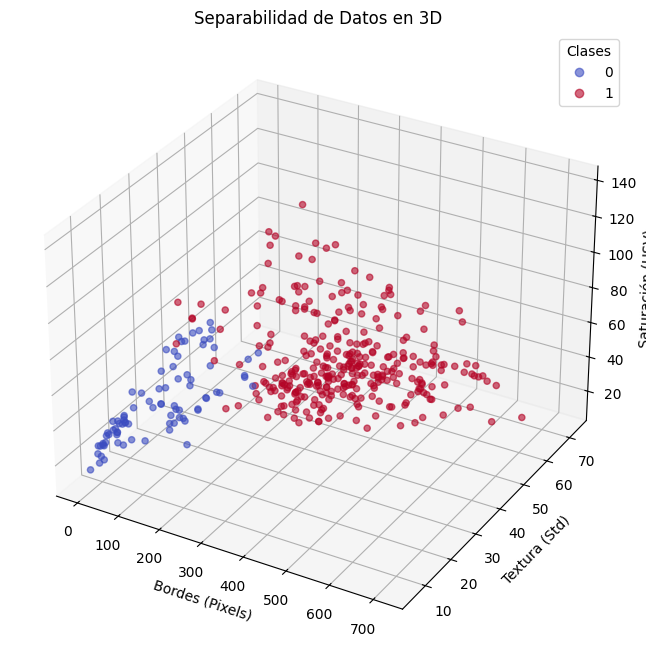

In [10]:
plt.figure(figsize=(10, 8))

# 3D Plot para las 3 features
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X[:,0], X[:,1], X[:,2], c=y, cmap='coolwarm', alpha=0.6)

ax.set_xlabel('Bordes (Pixels)')
ax.set_ylabel('Textura (Std)')
ax.set_zlabel('Saturación (HSV)')
plt.title('Separabilidad de Datos en 3D')
plt.legend(*scatter.legend_elements(), title="Clases")
plt.show()

## 4. Entrenar Modelo SVM
Usaremos un **Kernel RBF** (Radial Basis Function) para permitir fronteras de decisión curvas si es necesario.

🏆 Accuracy en Test: 100.00%

📜 Reporte de Clasificación:
              precision    recall  f1-score   support

       Libre       1.00      1.00      1.00        17
     Ocupado       1.00      1.00      1.00        65

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



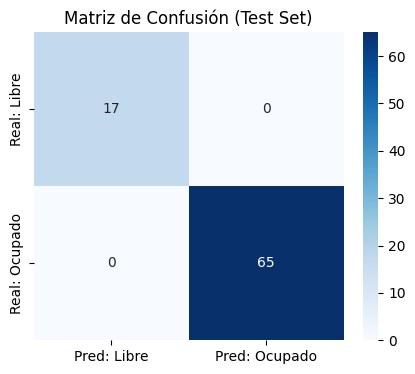

In [11]:
# 1. Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Escalar Datos (¡CRITICO para SVM!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Entrenar SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_model.fit(X_train_scaled, y_train)

# 4. Evaluar
y_pred = svm_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"🏆 Accuracy en Test: {acc*100:.2f}%")
print("\n📜 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Libre', 'Ocupado']))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Libre', 'Pred: Ocupado'], 
            yticklabels=['Real: Libre', 'Real: Ocupado'])
plt.title('Matriz de Confusión (Test Set)')
plt.show()

## 5. Guardar Modelo
Guardamos tanto el modelo como el "scaler" (necesario para procesar nuevas fotos igual).

In [12]:
model_data = {
    "model": svm_model,
    "scaler": scaler
}

with open(MODEL_FILE, 'wb') as f:
    pickle.dump(model_data, f)
    
print(f"💾 Modelo guardado exitosamente en: {MODEL_FILE}")
print("🚀 ¡Ahora puedes usar este modelo en tu detector en tiempo real!")

💾 Modelo guardado exitosamente en: model.pkl
🚀 ¡Ahora puedes usar este modelo en tu detector en tiempo real!
